In [28]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import xarray as xr

In [20]:
# set argument
raster = 'Rasters/phenoshapeAll.tif'
shp = 'SHP/Suisun_mask.shp'
output = raster[:-4] + "_masked.tif"

In [37]:
def dissolve_all(shp):
    # add dummy field to perform the dissolve
    shp.loc[:, "dissolve"] = 1
    # perform dissolve
    print("Dissolving vector file...")
    return shp.dissolve(by = "dissolve")

In [29]:
shp = gpd.read_file(shp)
shp.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
shp = dissolve_all(shp)
shp

Dissolving vector file...


,geometry,OBJECTID,NVCSName,NVCSLevel,MapClass,MapClassCo,Original_2,Original_1,Cov_2015,Dist_2015,...,Rare,CaCode,NVCSAllian,NVCSGroup,NVCSMG,UID,Acres,Hectares,Shape_Leng,Shape_Area
dissolve,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((576350.923 4212238.149, 576358...",1.0,Distichlis spicata - Juncus arcticus var. balt...,Association,Distichlis spicata - Juncus arcticus var. balt...,8111203,Distichlis spicata-Juncus balticus Association,145,25-50%,Not evident,...,N,41.200.05,Distichlis spicata,Temperate Pacific tidal salt and brackish meadow,North American Pacific Coastal Salt Marsh,SUMA00001,0.790708,0.319988,391.468421,3199.511517


In [33]:
# check raster
img = xr.open_rasterio(raster)
img

/tmp/ipykernel_8400/1416610165.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  img = xr.open_rasterio(raster)


<xarray.DataArray (band: 52, y: 2337, x: 2530)>
[307455720 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52
  * y        (y) float64 4.234e+06 4.234e+06 4.234e+06 ... 4.21e+06 4.21e+06
  * x        (x) float64 5.756e+05 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
Attributes:
    transform:      (10.0, 0.0, 575570.0, 0.0, -10.0, 4233810.0)
    crs:            +init=epsg:32610
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area

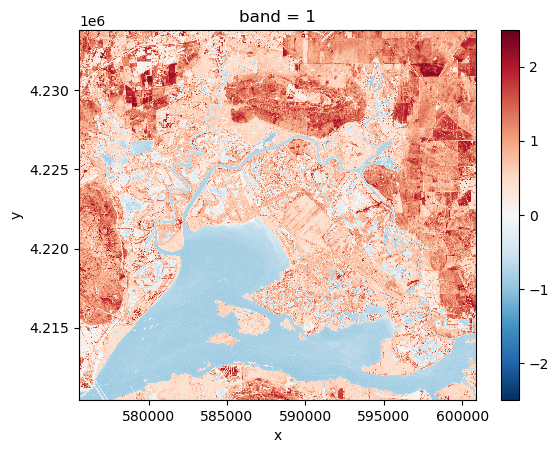

In [15]:
img.isel(band=0).plot()

In [16]:
del img

In [39]:
# load shapefile shapes
features = shp.geometry

# open and crop raster
print("Clipping raster...")
with rasterio.open(raster) as src:
    img, transform = rasterio.mask.mask(src, features, crop=True)
    img[img == 0] = np.nan
    meta = src.meta.copy()

    

meta.update({"driver": "GTiff",
             "height": img.shape[1],
             "width": img.shape[2],
             "transform": transform})

# save
with rasterio.open(output, 'w', **meta) as dst:
    dst.write(img)

Clipping raster...


In [40]:
img = xr.open_rasterio(output)
img

/tmp/ipykernel_8400/3427562205.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  img = xr.open_rasterio(output)


<xarray.DataArray (band: 52, y: 2243, x: 2530)>
[295089080 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52
  * y        (y) float64 4.234e+06 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x        (x) float64 5.756e+05 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
Attributes:
    transform:      (10.0, 0.0, 575570.0, 0.0, -10.0, 4233810.0)
    crs:            +init=epsg:32610
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area

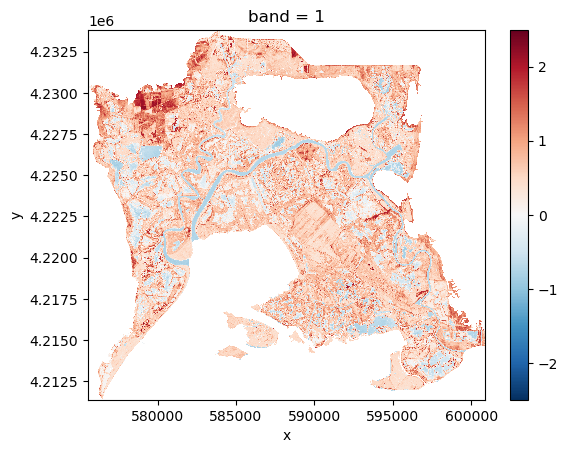

In [41]:
img.isel(band=0).plot()